# Drug Prescription Effectiveness and Ratings
### Dataset 
This dataset deals with prescription drugs; it was found on Kaggle from user Rohan Harode.

Link: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018

#### Attributes
* _Drug_: Name of drug
* _condition_: Name of condition the drug intends to treat
* _date_: date of review and rating entry
* _Effectiveness_: 5 star patient review
* _Age_: age range of the patient
* _EaseOfUse_: 5 star rating of how easy the drug is to use
* _Satisfaction_: 5 star rating of how the patients liked the drug
* _Sex_: gender of patient

* _*Both 'usefulCount' and 'review' attributes were ommitted; they will serve no use in the predictions_

#### Predictions
We are trying to predict the effectiveness of each drug based on an unseen patient. To do this, we will need to find the average effectiveness of each drug grouped by drug name.

In [150]:
# some useful mysklearn package import statements and reloads
import importlib
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import plot_utils as plot
importlib.reload(plot)

import copy

In [151]:
# Dataset Preprocessing
table, header = myutils.get_tables("input_data/webmd.csv")
drug_table = MyPyTable(header, table)

drug_table.remove_rows_with_missing_values()
drug_table.convert_to_numeric()
to_rem = drug_table.find_duplicates(['Drug','Age','Condition','Date','EaseofUse','Satisfaction','Sex','UsefulCount','Effectiveness'])
drug_table.drop_rows(to_rem)

# remove non-useful attributes
for i in range(len(drug_table.data)):
    del drug_table.data[i][7]

del drug_table.column_names[7]

# convert dates to seasons, change some misc age values
drug_table.column_names[3] = 'Season'
for i in range(len(drug_table.data)):
    val = drug_table.data[i][3]
    newVal = myutils.season_discretize(val)
    drug_table.data[i][3] = newVal

    if drug_table.data[i][1] == '6-Mar':
        drug_table.data[i][1] = '3-6'
    if drug_table.data[i][1] == '12-Jul':
        drug_table.data[i][1] = '7-12'

drug_table.save_to_file('input_data/clean_drug.csv')

In [152]:
import statistics

# stats - group by 'Drug'
values, counts = drug_table.get_frequencies('Drug')

grouped_data = []
for item in values:
    grouped_data.append([])

for item in drug_table.data:
    ind = values.index(item[0])
    grouped_data[ind].append(item)

drug_avg_data = []
for i in range(len(grouped_data)):
    instance = []
    instance.append(grouped_data[i][0][0])

    mean_lists = []
    for n in range(7):
        mean_lists.append([])

    for item in grouped_data[i]:
        for j in range(len(item)):
            if j == 0:
                pass
            else:
                mean_lists[j-1].append(item[j])
    
    for item in mean_lists:
        if isinstance(item[0], float):
            instance.append(round(statistics.mean(item), 2))
        else:
            instance.append(myutils.get_most_frequent(item))

    drug_avg_data.append(instance)

avg_drug_table = MyPyTable()
avg_drug_table.data = drug_avg_data
avg_drug_table.column_names = drug_table.column_names

To compute the effectiveness of each drug and display classification information on each instance, we had to convert the class label  
into a categorical label. Instead of having an Effectiveness integer value between 0.0 and 5.0, we converted each Effectiveness  
value to the following categorical values:
- 0.0 to 1.0: Not_Effective ("NE")
- 1.01 to 2.0: Slightly_Effective ("SE")
- 2.01 to 3.0: Moderately_Effective ("ME")
- 3.01 to 4.0: Effective ("E")
- 4.01 to 5.0: Very_Effective ("VE")

The same was done to the Satisfaction and EaseofUse attributes after creating charts of their values.

In [153]:
# create categorical attribute of effectiveness
# convert effectiveness rating into categorical rating
effectiveness_con = myutils.get_column(avg_drug_table.data, avg_drug_table.column_names, "Effectiveness")
effectiveness_cat = myutils.continuous_to_categorical(effectiveness_con)
for i in range(len(avg_drug_table.data)):
    avg_drug_table.data[i][-1] = effectiveness_cat[i]

avg_drug_table.save_to_file('input_data/grouped_data.csv')

## EDA - Statistics

### Boxplots

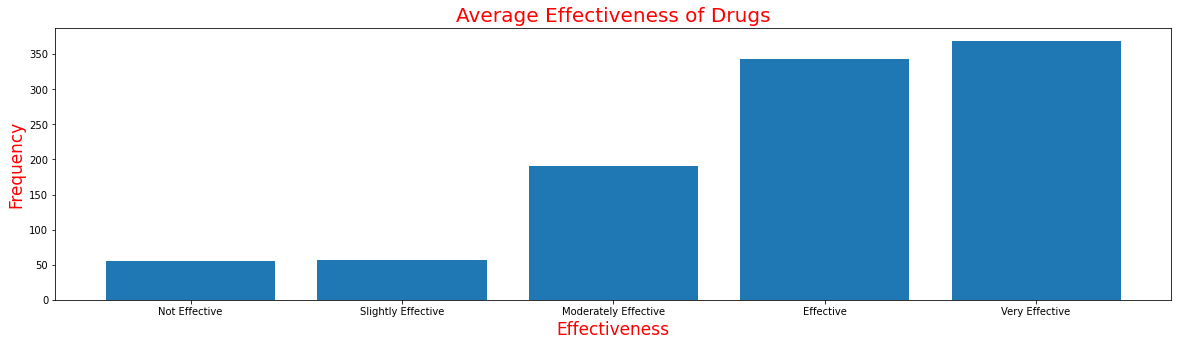

In [154]:
# Boxplot of each class label
eff_vals, eff_counts = avg_drug_table.get_frequencies('Effectiveness')
count_ord = []
l = [2, 3, 1, 0, 4]
for item in l:
    count_ord.append(eff_counts[item])

labels = ['Not Effective', 'Slightly Effective', 'Moderately Effective', 'Effective', 'Very Effective']
plot.bar_chart(labels, count_ord, "Average Effectiveness of Drugs", "Effectiveness", "Frequency")

Overall, the effectiveness levels of each drug are overwhelmingly positive. The 'Very Effective' and 'Effective' classifications dwarf the others.

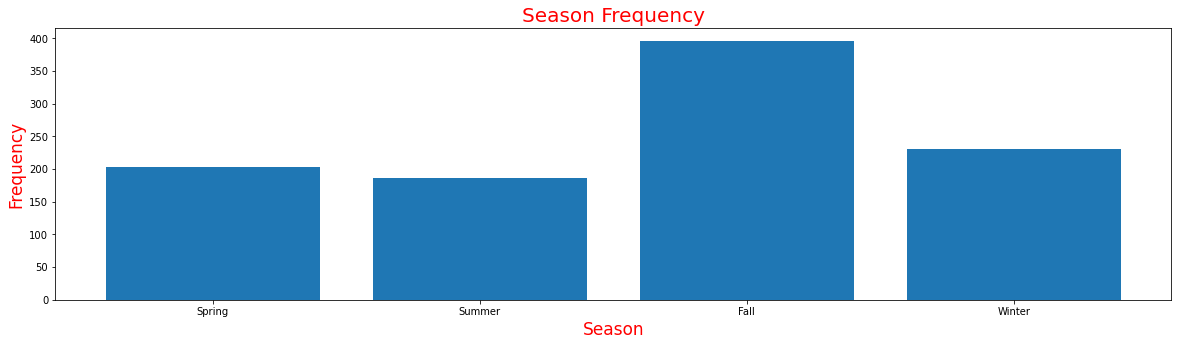

In [155]:
# Boxplot of seasons
sz_vals, sz_counts = avg_drug_table.get_frequencies('Season')
count_ord = []
l = [1, 2, 0, 3]
for item in l:
    count_ord.append(sz_counts[item])

plot.bar_chart(['Spring', 'Summer', 'Fall', 'Winter'], count_ord, "Season Frequency", "Season", "Frequency")

There seems to be more drugs prescribed in the Fall and Winter as opposed to Spring and Summer. Perhaps it is the colder weather that leads into more sickness.

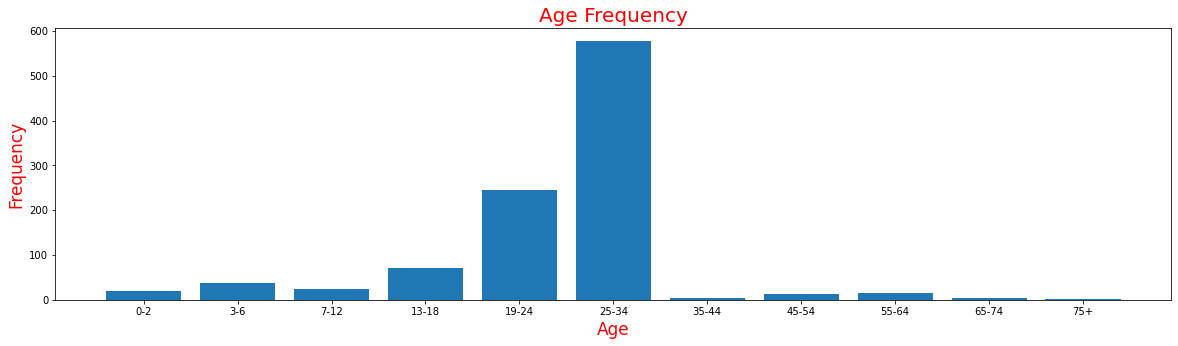

In [156]:
# Boxplot of age
age_vals, age_counts = avg_drug_table.get_frequencies('Age')
count_ord = []

l = [0, 4, 9, 1, 2, 3, 5, 6, 7, 8, 10]
for item in l:
    count_ord.append(age_counts[item])

plot.bar_chart(['0-2', '3-6', '7-12', '13-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+'], count_ord, "Age Frequency", "Age", "Frequency")

25-34 year olds dominate the majority of the instances. The distribution of age categories is strongly skewed towards the younger population.

### Scatter Plots

y = 0.7222 x + 0.724
r: 0.63
Covariance: 0.75


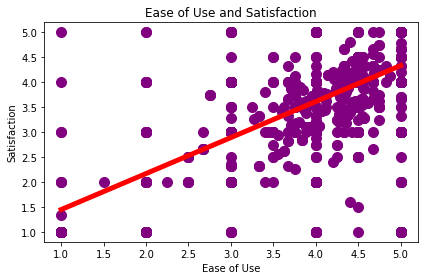

In [157]:
eou_data = avg_drug_table.get_column('EaseofUse')
satisfaction_data = avg_drug_table.get_column('Satisfaction')

plot.scatter_chart(eou_data, satisfaction_data, "Ease of Use and Satisfaction", 'Ease of Use', 'Satisfaction')

With an r-value of 0.63, there is a moderately strong correlation between ease of use and satisfaction (understandbly). It is worth noting that the concentration of data is in the higher end range of each variable.

## ML Models 

### Dummy Classifier

In [158]:
# normalize EaseofUse and Satisfaction
ease_con = myutils.get_column(avg_drug_table.data, avg_drug_table.column_names, "EaseofUse")
ease_cat = myutils.continuous_to_categorical(ease_con)
for i in range(len(avg_drug_table.data)):
    avg_drug_table.data[i][4] = ease_cat[i]

satisfaction_con = myutils.get_column(avg_drug_table.data, avg_drug_table.column_names, "Satisfaction")
satisfaction_cat = myutils.continuous_to_categorical(satisfaction_con)
for i in range(len(avg_drug_table.data)):
    avg_drug_table.data[i][5] = satisfaction_cat[i]
avg_drug_table.save_to_file('input_data/grouped_data.csv')

# get X and y for stratified k fold cross validation
X = []
y = []
for i in range(len(avg_drug_table.data)):
    # create X, y, remove class label from X
    X.append(avg_drug_table.data[i].copy()) 
    y.append(avg_drug_table.data[i][-1]) # class label
# remove class label from X
for row in X:
    row.pop(-1)

# get folds
X_train_folds, X_test_folds = myevaluation.stratified_kfold_cross_validation(X, y, n_splits=5, random_state=None, shuffle=True)

# create training/testing sets out of the folds
X_train_sets, y_train_sets = myutils.get_sets_from_folds(X, y, X_train_folds)
X_test_sets, y_test_sets = myutils.get_sets_from_folds(X, y, X_test_folds)

labels = ["VE", "E", "ME", "SE", "NE"]
dummy = MyDummyClassifier()
myutils.fit_predict_classification(X_train_sets, y_train_sets, 
    X_test_sets, y_test_sets, dummy, "Dummy", labels)


Dummy Classification
Accuracy: 0.37 ~ Error Rate: 0.63
Recall Score: 1.0
Precision Score: 0.36
F1 Score: 0.53

Confusion Matrix:
+-----+---+----+----+----+
| VE  | E | ME | SE | NE |
+-----+---+----+----+----+
| 369 | 0 | 0  | 0  | 0  |
| 343 | 0 | 0  | 0  | 0  |
| 191 | 0 | 0  | 0  | 0  |
| 57  | 0 | 0  | 0  | 0  |
| 56  | 0 | 0  | 0  | 0  |
+-----+---+----+----+----+


In [159]:
knn = MyKNeighborsClassifier()
myutils.fit_predict_classification(X_train_sets, y_train_sets, 
    X_test_sets, y_test_sets, knn, "KNN", labels)

KNN Classification
Accuracy: 0.29 ~ Error Rate: 0.71
Recall Score: 0.54
Precision Score: 0.78
F1 Score: 0.64

Confusion Matrix:
+-----+-----+-----+----+----+
| VE  |  E  | ME  | SE | NE |
+-----+-----+-----+----+----+
| 290 | 59  | 20  | 0  | 0  |
| 62  | 240 | 37  | 3  | 1  |
| 10  | 54  | 116 | 10 | 1  |
|  3  | 11  | 19  | 17 | 7  |
|  6  |  7  |  8  | 4  | 31 |
+-----+-----+-----+----+----+


In [160]:
def x_rem(sets):
    newSets = []
    for set in sets:
        newSet = []
        for instance in set:
            newIns = []
            for i in range(len(instance)):
                if i == 0 or i == 2:
                    pass
                # elif i == 4 or i == 5:
                #     val = myutils.continuous_to_categorical([instance[i]])
                #     newIns.append(val[0])
                else:
                    newIns.append(instance[i])
            newSet.append(newIns)
        newSets.append(newSet)

    return newSets


x_dec_train_sets = x_rem(X_train_sets)
x_dec_test_sets = x_rem(X_test_sets)

myutils.fit_predict_classification(x_dec_train_sets, y_train_sets, x_dec_test_sets, 
    y_test_sets, MyDecisionTreeClassifier(), 'Decision Tree', labels)
print() 

Decision Tree Classification
Accuracy: 0.29 ~ Error Rate: 0.71
Recall Score: 0.57
Precision Score: 0.83
F1 Score: 0.67

Confusion Matrix:
+-----+-----+-----+----+----+
| VE  |  E  | ME  | SE | NE |
+-----+-----+-----+----+----+
| 297 | 55  | 12  | 1  | 4  |
| 51  | 247 | 41  | 0  | 4  |
|  6  | 47  | 133 | 3  | 2  |
|  0  |  6  | 30  | 4  | 17 |
|  1  |  0  |  5  | 0  | 50 |
+-----+-----+-----+----+----+



In [161]:
forest = MyRandomForestClassifier(N=8, F=4, M=3)
myutils.fit_predict_classification(x_dec_train_sets, y_train_sets, x_dec_test_sets, y_test_sets, forest, "Forest", labels)

Forest Classification
Accuracy: 0.3 ~ Error Rate: 0.7
Recall Score: 0.54
Precision Score: 0.8
F1 Score: 0.64

Confusion Matrix:
+-----+-----+-----+----+----+
| VE  |  E  | ME  | SE | NE |
+-----+-----+-----+----+----+
| 289 | 64  | 11  | 1  | 4  |
| 59  | 253 | 26  | 3  | 2  |
| 12  | 57  | 114 | 5  | 3  |
|  1  | 15  | 24  | 5  | 12 |
|  0  |  9  |  3  | 8  | 36 |
+-----+-----+-----+----+----+
